In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing



In [ ]:
import pandas as pd
import glob

# Define the column names manually.
columns = [
    "customer_id", "age_band", "gender", "date", "date_transaction_id",
    "event_type", "game_type", "wager_amount", "win_loss", "win_loss_amount",
    "initial_balance", "ending_balance", "withdrawal_amount", "deposit_amount"
]

folder_path = '/content/drive/MyDrive/dataset/'

csv_files = glob.glob(folder_path + "*.csv")
print("CSV files found:", csv_files)

if not csv_files:
    raise ValueError("No CSV files found. Check your folder path and file pattern.")

# Read each CSV file into a DataFrame, assign the column names, and store in a list.
df_list = []
for file in csv_files:
    df = pd.read_csv(file, header=None)  # assuming the CSV files have no headers
    df.columns = columns
    df_list.append(df)

# Concatenate all DataFrames into one.
combined_df = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime for proper sorting.
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Sort by customer_id, date, and date_transaction_id.
combined_df = combined_df.sort_values(by=['customer_id', 'date', 'date_transaction_id'])

# Define a function that updates only the first row of each customer group.
def update_first_transaction_info(group):
    # Assumes group is already sorted; first row is the earliest transaction.
    first_idx = group.index[0]
    # For age_band:
    if pd.isnull(group.at[first_idx, 'age_band']):
        non_null_age = group['age_band'].dropna()
        if not non_null_age.empty:
            group.at[first_idx, 'age_band'] = non_null_age.iloc[0]
    # For gender:
    if pd.isnull(group.at[first_idx, 'gender']):
        non_null_gender = group['gender'].dropna()
        if not non_null_gender.empty:
            group.at[first_idx, 'gender'] = non_null_gender.iloc[0]
    return group

# Apply the function to each customer group.
combined_df = combined_df.groupby('customer_id', group_keys=False).apply(update_first_transaction_info)

# Save the combined DataFrame to a new CSV file.
combined_df.to_csv("combined.csv", index=False)

# Print out basic info to verify the data was read and updated correctly.
print("Combined DataFrame shape:", combined_df.shape)
print("First 5 rows of the combined DataFrame:")
print(combined_df.head())


Changes to data types

In [ ]:
# Convert categorical columns to 'category' dtype for efficiency
categorical_cols = ['customer_id', 'age_band', 'gender', 'event_type', 'game_type', 'win_loss']
for col in categorical_cols:
    combined_df[col] = combined_df[col].astype('category')

# If date_transaction_id is truly an integer, convert it
combined_df['date_transaction_id'] = combined_df['date_transaction_id'].fillna(0).astype(int)

# Quick check of the updated dtypes:
print(combined_df.dtypes)


# Only keep the data we need for training

In [ ]:
import pandas as pd

# 1. Filter to keep only transactions with event_type 'bet' or 'flagged_high_risk'
df_filtered = combined_df[combined_df['event_type'].isin(['bet', 'flagged_high_risk'])].copy()

# 2. Create a flagged column: 1 if event_type is 'flagged_high_risk', else 0
df_filtered['flagged'] = (df_filtered['event_type'] == 'flagged_high_risk').astype(int)

# 3. Ensure date_transaction_id is numeric (just to be safe)
df_filtered['date_transaction_id'] = pd.to_numeric(df_filtered['date_transaction_id'], errors='coerce')

# 4. Group by customer_id and date, aggregating:
#    - 'wager_sum': the sum of wager_amount,
#    - 'bets_amount': the count of transactions,
#    - 'flagged': maximum flagged value for that day (1 if any transaction was flagged)
aggregated_df = df_filtered.groupby(['customer_id', 'date'], observed=True).agg({
    'wager_amount': 'sum',
    'date_transaction_id': 'count',
    'flagged': 'max'
}).reset_index()

# 5. Rename columns appropriately
aggregated_df.columns = ['customer_id', 'date', 'wager_sum', 'bets_amount', 'flagged']

# 6. Create a new column 'daily_average_wager' that is wager_sum divided by bets_amount (as a float)
aggregated_df['daily_average_wager'] = (aggregated_df['wager_sum'] / aggregated_df['bets_amount']).astype(float)

# Optionally, drop the original wager_sum column if it's no longer needed:
aggregated_df.drop(columns=['wager_sum'], inplace=True)

# 7. Print the results
print(aggregated_df)

                                 customer_id       date  bets_amount  flagged  \
0       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-01            4        0   
1       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-02            2        0   
2       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-04           15        0   
3       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-05            9        0   
4       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-06            6        0   
...                                      ...        ...          ...      ...   
128619  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-11-25           15        0   
128620  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-12-05           12        0   
128621  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-01           10        0   
128622  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-02            6        0   
128623  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-16            6        0   

        daily_average_wager

In [ ]:
# Ensure the DataFrame is sorted by customer and date for proper rolling calculations
aggregated_df = aggregated_df.sort_values(['customer_id', 'date'])

# Compute the 10-row rolling average for bets_amount (using min_periods=1 to pad)
aggregated_df['bets_amount_7_avg'] = aggregated_df.groupby('customer_id')['bets_amount'] \
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Compute the 10-row rolling average for daily_average_wager (using min_periods=1 to pad)
aggregated_df['daily_average_wager_7_avg'] = aggregated_df.groupby('customer_id')['daily_average_wager'] \
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())

print(aggregated_df)

<ipython-input-19-e3ce94aa2718>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df['bets_amount_7_avg'] = aggregated_df.groupby('customer_id')['bets_amount'] \
<ipython-input-19-e3ce94aa2718>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df['daily_average_wager_7_avg'] = aggregated_df.groupby('customer_id')['daily_average_wager'] \


                                 customer_id       date  bets_amount  flagged  \
0       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-01            4        0   
1       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-02            2        0   
2       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-04           15        0   
3       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-05            9        0   
4       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-06            6        0   
...                                      ...        ...          ...      ...   
128619  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-11-25           15        0   
128620  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-12-05           12        0   
128621  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-01           10        0   
128622  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-02            6        0   
128623  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-16            6        0   

        daily_average_wager

In [ ]:
import pandas as pd

def rolling_date_range(group):
    # Sort the transactions by date for the customer
    group = group.sort_values('date')
    ranges = []
    for i in range(len(group)):
        # Define a window of up to the last 10 transactions (including current)
        window = group.iloc[max(0, i-9): i+1]
        # Compute the date range in days for this window
        days_range = (window['date'].max() - window['date'].min()).days
        ranges.append(days_range)
    return pd.Series(ranges, index=group.index)

# Sort the aggregated_df by customer_id and date
aggregated_df = aggregated_df.sort_values(['customer_id', 'date'])

# Apply the rolling date range calculation for each customer
aggregated_df['rolling_date_range'] = aggregated_df.groupby('customer_id', group_keys=False).apply(rolling_date_range)

print(aggregated_df)


<ipython-input-20-f5db53d60cfa>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df['rolling_date_range'] = aggregated_df.groupby('customer_id', group_keys=False).apply(rolling_date_range)


                                 customer_id       date  bets_amount  flagged  \
0       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-01            4        0   
1       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-02            2        0   
2       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-04           15        0   
3       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-05            9        0   
4       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-06            6        0   
...                                      ...        ...          ...      ...   
128619  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-11-25           15        0   
128620  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-12-05           12        0   
128621  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-01           10        0   
128622  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-02            6        0   
128623  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-16            6        0   

        daily_average_wager

<ipython-input-20-f5db53d60cfa>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  aggregated_df['rolling_date_range'] = aggregated_df.groupby('customer_id', group_keys=False).apply(rolling_date_range)
<ipython-input-20-f5db53d60cfa>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_df['rolling_date_range'] = aggregated_df.groupby('customer_id', group_keys=False).apply(rolling_date_range)


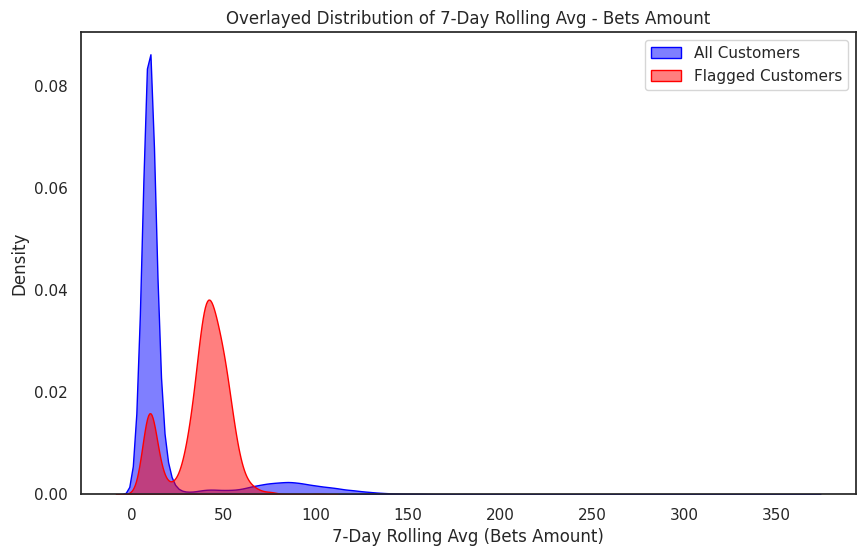

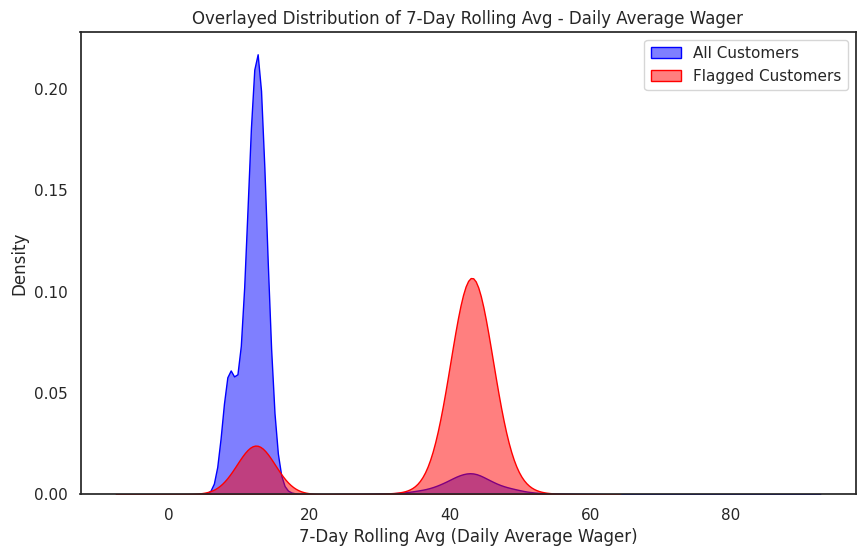

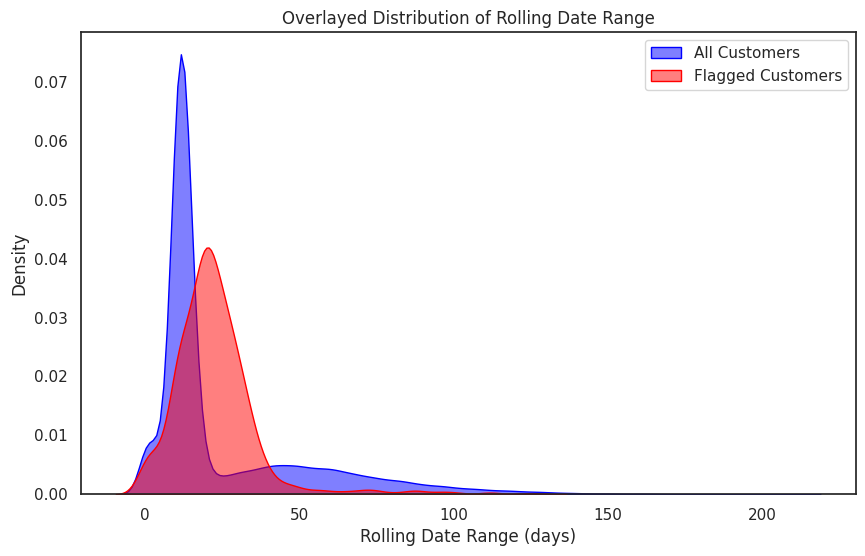

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a minimalist style for presentations
sns.set(style="white")

# Identify flagged customers (customers with at least one flagged day)
flagged_customers = aggregated_df[aggregated_df['flagged'] == 1]['customer_id'].unique()

# Filter aggregated_df to include all rows for flagged customers
flagged_customers_df = aggregated_df[aggregated_df['customer_id'].isin(flagged_customers)]

# Overlay for bets_amount 7-day rolling average using filled KDE curves
plt.figure(figsize=(10,6))
sns.kdeplot(aggregated_df['bets_amount_7_avg'], fill=True, color='blue', label='All Customers', alpha=0.5)
sns.kdeplot(flagged_customers_df['bets_amount_7_avg'], fill=True, color='red', label='Flagged Customers', alpha=0.5)
plt.title("Overlayed Distribution of 7-Day Rolling Avg - Bets Amount")
plt.xlabel("7-Day Rolling Avg (Bets Amount)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Overlay for daily_average_wager 7-day rolling average using filled KDE curves
plt.figure(figsize=(10,6))
sns.kdeplot(aggregated_df['daily_average_wager_7_avg'], fill=True, color='blue', label='All Customers', alpha=0.5)
sns.kdeplot(flagged_customers_df['daily_average_wager_7_avg'], fill=True, color='red', label='Flagged Customers', alpha=0.5)
plt.title("Overlayed Distribution of 7-Day Rolling Avg - Daily Average Wager")
plt.xlabel("7-Day Rolling Avg (Daily Average Wager)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Overlay for rolling_date_range using filled KDE curves
plt.figure(figsize=(10,6))
sns.kdeplot(aggregated_df['rolling_date_range'].dropna(), fill=True, color='blue', label='All Customers', alpha=0.5)
sns.kdeplot(flagged_customers_df['rolling_date_range'].dropna(), fill=True, color='red', label='Flagged Customers', alpha=0.5)
plt.title("Overlayed Distribution of Rolling Date Range")
plt.xlabel("Rolling Date Range (days)")
plt.ylabel("Density")
plt.legend()
plt.show()


Last cleanup of unused columns and high risk outliers

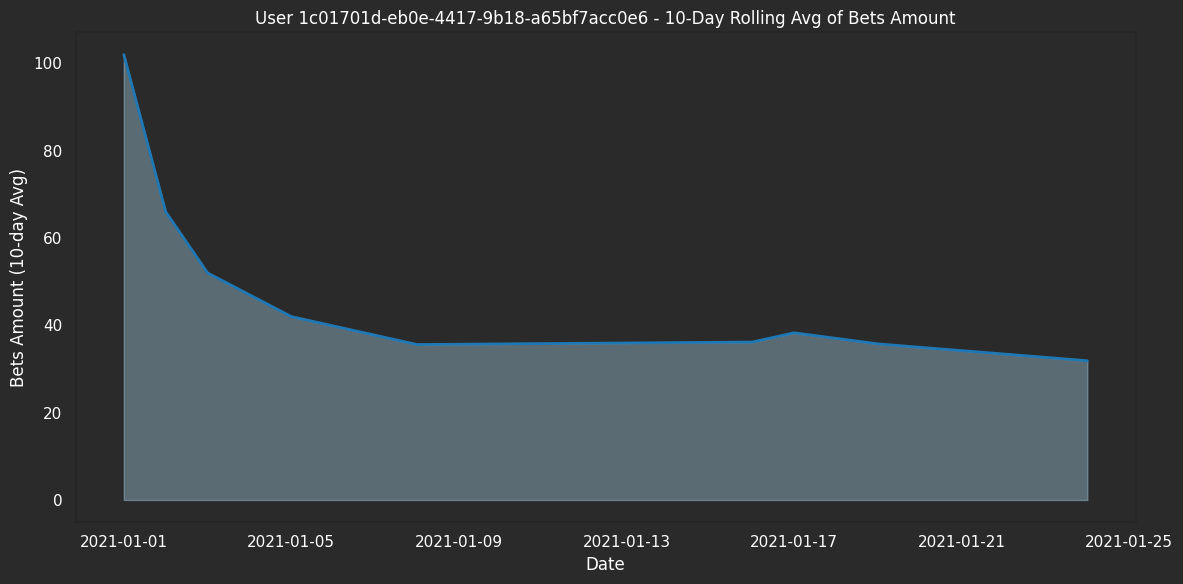

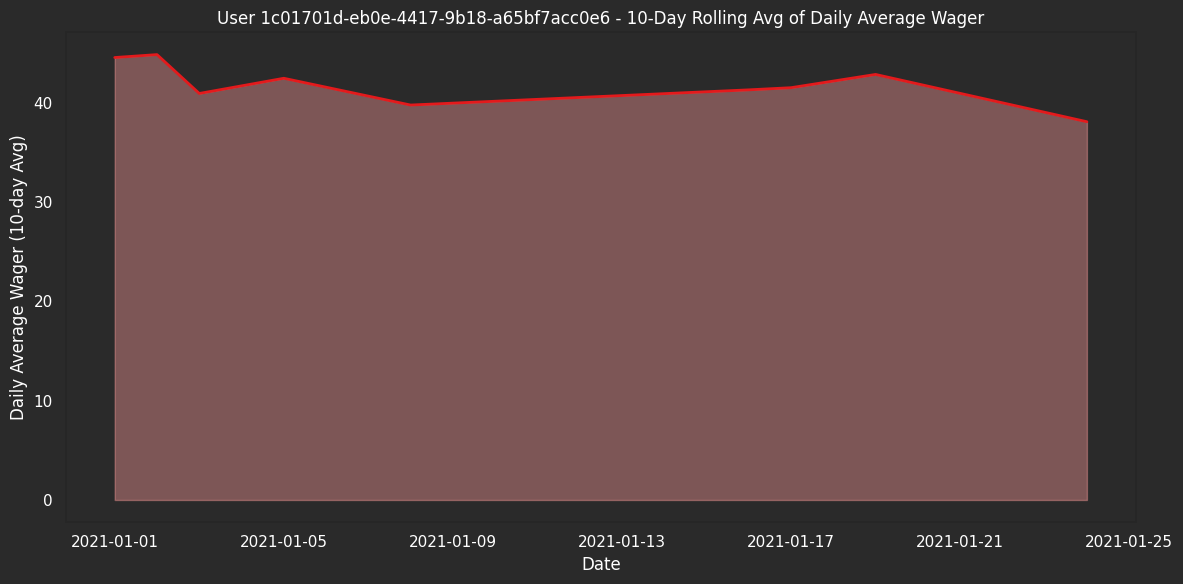

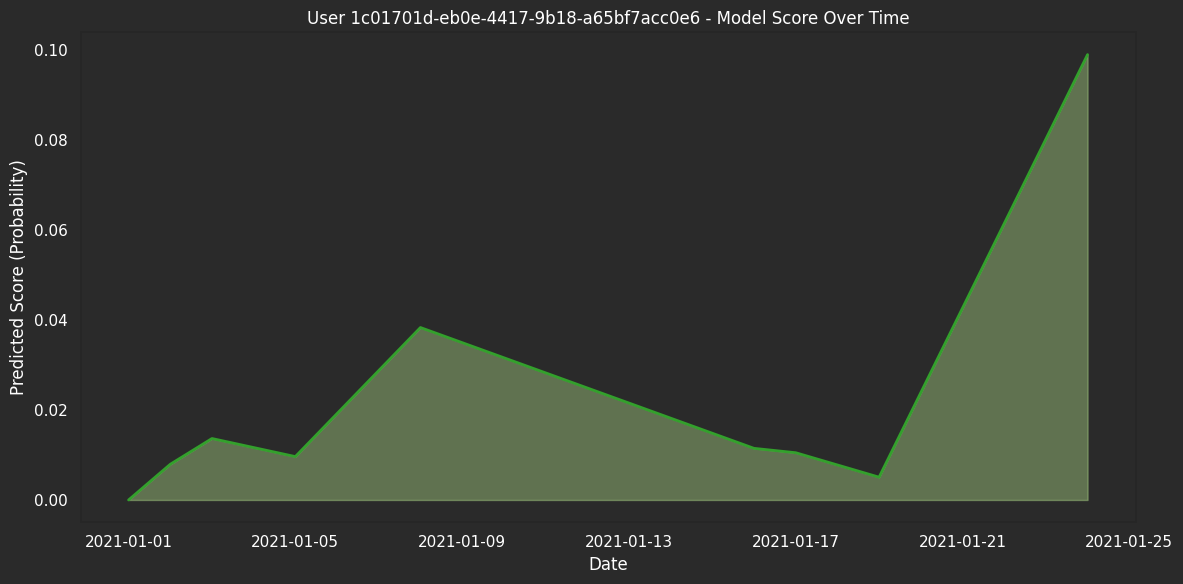

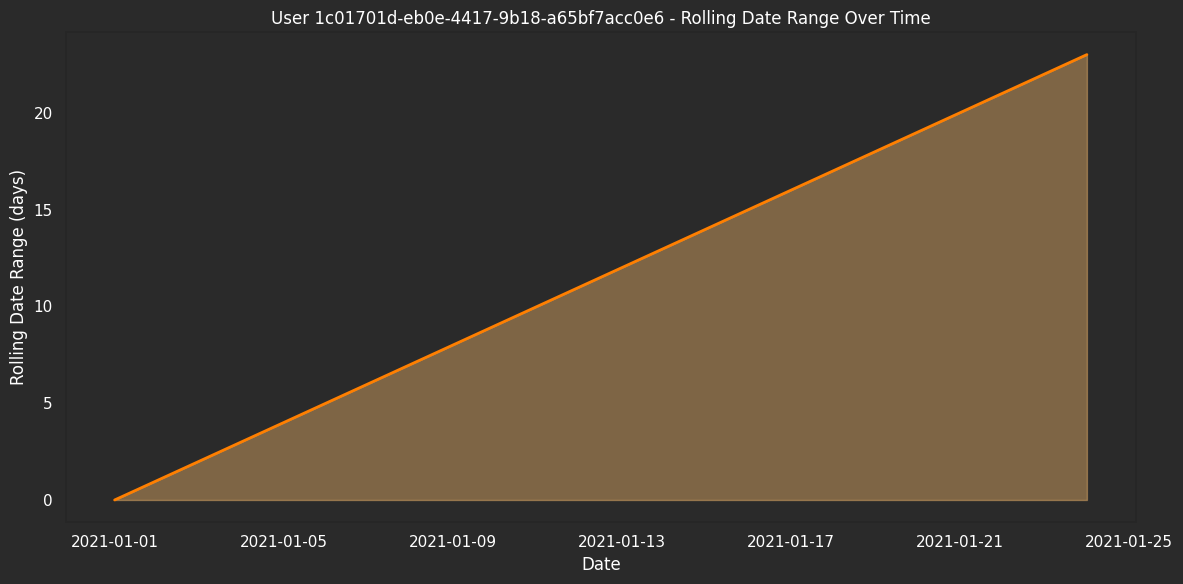

User 1c01701d-eb0e-4417-9b18-a65bf7acc0e6 gets flagged by the model on: 2021-01-02 00:00:00 with a score of: 0.007935701782660594
The flagged wager amount for user 1c01701d-eb0e-4417-9b18-a65bf7acc0e6 is: 55.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set a minimalist style; we will override colors later.
sns.set(style="white")
dark_bg = '#2A2A2A'

# Identify flagged customers
flagged_customers = aggregated_df[aggregated_df['flagged'] == 1]['customer_id'].unique()

# Choose a random flagged customer
random_user = np.random.choice(flagged_customers)

# Filter data for this flagged user and sort by date (assuming 'date' is a datetime column)
user_data = aggregated_df[aggregated_df['customer_id'] == random_user].sort_values('date').copy()

# Compute the model score for each feature pair
# (Assumes 'features' is defined as ['bets_amount_7_avg', 'daily_average_wager_7_avg']
# and that scaler and svm_model have been fit already.)
user_features = user_data[features]
user_features_scaled = scaler.transform(user_features)
user_scores = svm_model.predict_proba(user_features_scaled)[:, 1]
user_data['score'] = user_scores

# -----------------------------
# Graph 1: Bets Amount over Time
# -----------------------------
fig, ax = plt.subplots(figsize=(12,6), facecolor=dark_bg)
ax.set_facecolor(dark_bg)
line_color_bets = "#1f78b4"   # blue
fill_color_bets = "#a6cee3"   # lighter blue for fill
ax.plot(user_data['date'], user_data['bets_amount_7_avg'], color=line_color_bets, lw=2)
ax.fill_between(user_data['date'], user_data['bets_amount_7_avg'], color=fill_color_bets, alpha=0.4)
ax.set_title(f"User {random_user} - 10-Day Rolling Avg of Bets Amount", color='white')
ax.set_ylabel("Bets Amount (10-day Avg)", color='white')
ax.tick_params(colors='white')
ax.set_xlabel("Date", color='white')
plt.tight_layout()
plt.show()

# -----------------------------------------
# Graph 2: Daily Average Wager over Time
# -----------------------------------------
fig, ax = plt.subplots(figsize=(12,6), facecolor=dark_bg)
ax.set_facecolor(dark_bg)
line_color_wager = "#e31a1c"  # red
fill_color_wager = "#fb9a99"  # lighter red for fill
ax.plot(user_data['date'], user_data['daily_average_wager_7_avg'], color=line_color_wager, lw=2)
ax.fill_between(user_data['date'], user_data['daily_average_wager_7_avg'], color=fill_color_wager, alpha=0.4)
ax.set_title(f"User {random_user} - 10-Day Rolling Avg of Daily Average Wager", color='white')
ax.set_ylabel("Daily Average Wager (10-day Avg)", color='white')
ax.tick_params(colors='white')
ax.set_xlabel("Date", color='white')
plt.tight_layout()
plt.show()

# -------------------------------
# Graph 3: Model Score Over Time
# -------------------------------
fig, ax = plt.subplots(figsize=(12,6), facecolor=dark_bg)
ax.set_facecolor(dark_bg)
line_color_score = "#33a02c"  # green
fill_color_score = "#b2df8a"  # lighter green for fill
ax.plot(user_data['date'], user_data['score'], color=line_color_score, lw=2)
ax.fill_between(user_data['date'], user_data['score'], color=fill_color_score, alpha=0.4)
ax.set_title(f"User {random_user} - Model Score Over Time", color='white')
ax.set_ylabel("Predicted Score (Probability)", color='white')
ax.tick_params(colors='white')
ax.set_xlabel("Date", color='white')
plt.tight_layout()
plt.show()

# -----------------------------------------
# Graph 4: Rolling Date Range Over Time
# -----------------------------------------
fig, ax = plt.subplots(figsize=(12,6), facecolor=dark_bg)
ax.set_facecolor(dark_bg)
line_color_range = "#ff7f00"  # orange
fill_color_range = "#fdbf6f"  # lighter orange for fill
ax.plot(user_data['date'], user_data['rolling_date_range'], color=line_color_range, lw=2)
ax.fill_between(user_data['date'], user_data['rolling_date_range'], color=fill_color_range, alpha=0.4)
ax.set_title(f"User {random_user} - Rolling Date Range Over Time", color='white')
ax.set_ylabel("Rolling Date Range (days)", color='white')
ax.tick_params(colors='white')
ax.set_xlabel("Date", color='white')
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Identify the flagged date and display flagged wager amount
# -------------------------------------------------------
# Find the first date when the user's raw score meets/exceeds the threshold
flagged_instances = user_data[user_data['score'] >= threshold]
if not flagged_instances.empty:
    flagged_date = flagged_instances['date'].iloc[0]
    flagged_score = flagged_instances['score'].iloc[0]
    print(f"User {random_user} gets flagged by the model on: {flagged_date} with a score of: {flagged_score}")

    # From combined_df, get the last transaction before the flagged transaction
    # that has a non-null wager_amount.
    user_combined = combined_df[combined_df['customer_id'] == random_user].sort_values('date')
    prior_transactions = user_combined[(user_combined['date'] < flagged_date) &
                                       (user_combined['wager_amount'].notnull())]
    if not prior_transactions.empty:
        # Get the most recent transaction (by date) before the flagged date.
        last_wager_row = prior_transactions.iloc[-1]
        flagged_wager_amount = last_wager_row['wager_amount']
        print(f"The flagged wager amount for user {random_user} is: {flagged_wager_amount}")
    else:
        print(f"No prior wager amount found for user {random_user} before the flagged date.")
else:
    print(f"User {random_user} was never flagged by the model.")


Drop selected rows

In [ ]:
aggregated_df.drop(columns=['daily_average_wager', 'bets_amount'], inplace=True)

remove_ids = [
    '4ab7fd9e-a914-4118-8767-733314bffa7a',
    '38f6414f-db9d-470a-8620-a5671a56f1b6',
    '3bb4830e-ba7e-4e45-b62c-8c5b333ce169',
    'd7f869d9-6fb5-4d7c-b07b-a0675bdbe0ea',
    'a3332b1b-56d5-4ae7-b166-dd61ea321c7d',
    '477920da-02f5-4659-990e-ffc48036674e',
    '75bc4eca-db08-4bd5-9eea-890f8b669190'
]

aggregated_df = aggregated_df[~aggregated_df['customer_id'].isin(remove_ids)]
print(aggregated_df)

print(aggregated_df)


                                 customer_id       date  flagged  \
0       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-01        0   
1       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-02        0   
2       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-04        0   
3       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-05        0   
4       00110a49-65ac-40c6-b53c-e2e35aee57ba 2021-01-06        0   
...                                      ...        ...      ...   
128619  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-11-25        0   
128620  ffefe3df-6eb5-4333-b631-e7a28665aab9 2021-12-05        0   
128621  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-01        0   
128622  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-02        0   
128623  ffff982b-b42b-4c63-8fea-162fa66271a4 2021-01-16        0   

        bets_amount_7_avg  daily_average_wager_7_avg  rolling_date_range  
0                4.000000                  12.500000                   0  
1                3.000000        

Training and test split

In [ ]:
from sklearn.model_selection import train_test_split

# Keep customer_id and date for later identification
customer_ids = aggregated_df['customer_id']
dates = aggregated_df['date']

# Use only the specified features for training
features = ['bets_amount_7_avg', 'daily_average_wager_7_avg']
X = aggregated_df[features]
y = aggregated_df['flagged']

# Split X, y, customer_ids, and dates simultaneously
X_train, X_test, y_train, y_test, cust_train, cust_test, dates_train, dates_test = train_test_split(
    X, y, customer_ids, dates,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Customer IDs in Test set:", cust_test.unique())
print("Dates in Test set:", dates_test.unique())

Train set shape: (89795, 2)
Test set shape: (38484, 2)
Customer IDs in Test set: ['50843b80-7a45-4fe8-b770-e2739fa769f4', 'a3c4addd-34b1-4c5d-8759-85ad6f34af03', '93dd8a56-6575-41e6-9449-d5deade311a2', 'b93e7926-9a10-4f70-90c5-48695b0ae9b9', 'c9a59ab1-f740-4e0b-bb95-7d96e007c5c7', ..., 'f07249a5-dacb-4c3a-a09f-fd2d68c25619', '30ff5d81-90f2-492e-97bb-808f9a119dd9', '1e5b8d49-4dac-4209-8981-a6d3d3519215', '3f4ff91f-fb5e-4033-a166-f28d6a3bca43', 'a7da9681-60bf-437e-96d2-1ba9904da88d']
Length: 2970
Categories (4000, object): ['00110a49-65ac-40c6-b53c-e2e35aee57ba', '0014fd7c-532d-4030-846a-f8549f2e368a',
                            '0021f975-0aff-44dd-b01b-1b5ae37d3b22', '003d8710-a461-4360-89e6-958ecf01a43b', ...,
                            'ffc840f2-fae1-4b1c-82f3-45144481fe56', 'ffefe3df-6eb5-4333-b631-e7a28665aab9',
                            'fffaf931-0ef0-4768-926a-d010d5d99ea8', 'ffff982b-b42b-4c63-8fea-162fa66271a4']
Dates in Test set: <DatetimeArray>
['2021-01-14 00:00:00', '202

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np

# Compute the original scale_pos_weight (ratio of negatives to positives in the training data)
original_scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
# Increase the weight for the minority class by 5000 times the original ratio
scale_pos_weight = original_scale_pos_weight * 5000
print("scale_pos_weight:", scale_pos_weight)

# Since X_train and X_test already only contain our training features, no extra columns need to be dropped
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # Using AUC for evaluation
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 10,
    'gamma': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Use only the training set in evals
evals = [(dtrain, 'train')]

# Train the model for 1500 boosting rounds
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    evals=evals,
    verbose_eval=50
)

# Predict on the test set (probabilities)
preds = model.predict(dtest)

# Adjust the decision threshold to boost recall for the minority class
threshold = 0.4
predictions = [1 if pred > threshold else 0 for pred in preds]

# Evaluate performance
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, preds)
report = classification_report(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

print("Test accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print(report)
print("Confusion Matrix:")
print(cm)

scale_pos_weight: 17954000.0
[0]	train-auc:0.97862
[50]	train-auc:0.99290
[100]	train-auc:0.99265
[150]	train-auc:0.99211
[200]	train-auc:0.99192
[250]	train-auc:0.99194
[300]	train-auc:0.99225
[350]	train-auc:0.99230
[400]	train-auc:0.99225
[450]	train-auc:0.99234
[500]	train-auc:0.99227
[550]	train-auc:0.99379
[600]	train-auc:0.99442
[650]	train-auc:0.99440
[700]	train-auc:0.99440
[750]	train-auc:0.99508
[800]	train-auc:0.99515
[850]	train-auc:0.99524
[900]	train-auc:0.99545
[950]	train-auc:0.99562
[1000]	train-auc:0.99554
[1050]	train-auc:0.99569
[1100]	train-auc:0.99565
[1150]	train-auc:0.99605
[1200]	train-auc:0.99626
[1250]	train-auc:0.99646
[1300]	train-auc:0.99672
[1350]	train-auc:0.99698
[1400]	train-auc:0.99697
[1450]	train-auc:0.99720
[1499]	train-auc:0.99740
Test accuracy: 0.9864878910716142
ROC AUC: 0.994783827146783
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     38473
           1       0.02      0.91      0.04      

# Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Compute class distribution in y_train
counter = Counter(y_train)
print("Class distribution in y_train:", counter)

# Calculate class weights: total_samples / (n_classes * count for each class)
n_samples = len(y_train)
n_classes = len(counter)
class_weights = {cls: n_samples / (n_classes * count) for cls, count in counter.items()}
print("Computed class weights:", class_weights)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with class weights
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, class_weight=class_weights)
lr_model.fit(X_train_scaled, y_train)

# Predict probabilities and convert them to class predictions (threshold = 0.5)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
predictions = (y_pred_proba > 0.5).astype(int)

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
print("Test accuracy:", accuracy_score(y_test, predictions))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


Class distribution in y_train: Counter({0: 89770, 1: 25})
Computed class weights: {0: 0.5001392447365489, 1: 1795.9}
Test accuracy: 0.894189793160794
ROC AUC: 0.9713518098879261
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     38473
           1       0.00      1.00      0.01        11

    accuracy                           0.89     38484
   macro avg       0.50      0.95      0.47     38484
weighted avg       1.00      0.89      0.94     38484

Confusion Matrix:
[[34401  4072]
 [    0    11]]


# SVM

In [ ]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# --- Data Preparation ---

# Keep customer_id and date for later identification
customer_ids = aggregated_df['customer_id']
dates = aggregated_df['date']

# Use only the selected features for training
features = ['bets_amount_7_avg', 'daily_average_wager_7_avg']
X = aggregated_df[features]
y = aggregated_df['flagged']

# Split X, y, customer_ids, and dates simultaneously
X_train, X_test, y_train, y_test, cust_train, cust_test, dates_train, dates_test = train_test_split(
    X, y, customer_ids, dates,
    test_size=0.30,
    stratify=y,
    random_state=110  # For reproducibility; adjust as needed
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# --- Class Weights Calculation ---

# Compute class distribution and corresponding weights to handle imbalance
counter = Counter(y_train)
print("Class distribution in y_train:", counter)
n_samples = len(y_train)
n_classes = len(counter)
class_weights = {cls: n_samples / (n_classes * count) for cls, count in counter.items()}
print("Computed class weights:", class_weights)

# --- Feature Scaling ---

# Normalize numerical features; SVM is sensitive to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- SVM Training ---
svm_model = SVC(
    probability=True,
    class_weight=class_weights,
    kernel='rbf',
    C=100,
    gamma=1.2,
    random_state=110
)
svm_model.fit(X_train_scaled, y_train)

# --- Prediction & Threshold Adjustment ---

# Predict probabilities for the positive class using the trained SVM model
y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Determine a threshold that ensures all actual positive cases are captured
threshold = y_pred_proba[y_test == 1].min()
print("Selected threshold to capture all positives:", threshold)

# Apply the threshold to get binary predictions
predictions = (y_pred_proba >= threshold).astype(int)

# --- Evaluation ---

accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

print("Test accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

Train set shape: (89795, 2)
Test set shape: (38484, 2)
Class distribution in y_train: Counter({0: 89770, 1: 25})
Computed class weights: {0: 0.5001392447365489, 1: 1795.9}
Selected threshold to capture all positives: 0.007193985911426731
Test accuracy: 0.98906038873298
ROC AUC: 0.994697580121124
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     38473
           1       0.03      1.00      0.05        11

    accuracy                           0.99     38484
   macro avg       0.51      0.99      0.52     38484
weighted avg       1.00      0.99      0.99     38484

Confusion Matrix:
[[38052   421]
 [    0    11]]


In [ ]:
import pandas as pd

# Ensure the 'date' column is in datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Compute model scores for each record using your pre-fitted scaler and svm_model.
features = ['bets_amount_7_avg', 'daily_average_wager_7_avg']
X = aggregated_df[features]
X_scaled = scaler.transform(X)
aggregated_df['score'] = svm_model.predict_proba(X_scaled)[:, 1]

# Flag records where the model score meets or exceeds the threshold.
aggregated_df['flagged_by_model'] = aggregated_df['score'] >= threshold

# Group by month (using dt.to_period('M')) and count unique customer_ids that were flagged.
monthly_flagged_users = (
    aggregated_df[aggregated_df['flagged_by_model']]
    .groupby(aggregated_df['date'].dt.to_period('M'))['customer_id']
    .nunique()
)

# Create a complete monthly range from the earliest to the latest month.
full_month_range = pd.period_range(
    start=aggregated_df['date'].min().to_period('M'),
    end=aggregated_df['date'].max().to_period('M'),
    freq='M'
)

# Reindex the series to include all months, filling missing months with 0.
monthly_flagged_users = monthly_flagged_users.reindex(full_month_range, fill_value=0)

# Multiply the monthly counts by 3.
monthly_flagged_users = monthly_flagged_users * 3

# Convert the Series to a DataFrame and format the month column as a string.
monthly_flagged_users_df = monthly_flagged_users.reset_index()
monthly_flagged_users_df.columns = ['month', 'flagged_count']
monthly_flagged_users_df['month'] = monthly_flagged_users_df['month'].astype(str)

# Export the DataFrame to a CSV file.
monthly_flagged_users_df.to_csv('monthly_flagged_users.csv', index=False)
print("CSV file 'monthly_flagged_users.csv' has been created.")


CSV file 'monthly_flagged_users.csv' has been created.


In [ ]:
import pickle
# --- Serialize the Model ---
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

# Optionally, you might also want to serialize the scaler if you plan to use it during inference:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Model and scaler have been serialized to 'svm_model.pkl' and 'scaler.pkl'.")

Model and scaler have been serialized to 'svm_model.pkl' and 'scaler.pkl'.
